In [1]:
%load_ext autoreload
%autoreload 2

In [3]:
from tensorflow.python.client import device_lib
device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 11834390173390457940, name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 11285538407
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 5261057869765223980
 physical_device_desc: "device: 0, name: Tesla K80, pci bus id: 0000:00:1e.0, compute capability: 3.7"]

In [2]:
from utils import *

import numpy as np
import tensorflow as tf
from tensorflow.keras import backend as K

/home/ubuntu/.local/share/virtualenvs/kaggle-salt-WGcE8zWi/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/home/ubuntu/.local/share/virtualenvs/kaggle-salt-WGcE8zWi/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


In [4]:
train_ids = load_array("data/train_ids.arr")
x_train = load_array("data/x_train.arr")
y_train = load_array("data/y_train.arr")
# test_ids = load_array("data/test_ids.arr")
# x_test = load_array("data/x_test.arr")

In [5]:
im_width = x_train.shape[1]
im_height = x_train.shape[2]
im_chan = x_train.shape[3]

In [6]:
x_train.shape, y_train.shape, im_width, im_height, im_chan

((4000, 128, 128, 1), (4000, 128, 128, 1), 128, 128, 1)

We define the metric we are going to use to evaluate: mean average precision at different intersection over union (IoU) thresholds

In [7]:
def mean_iou(y_true, y_pred):
    prec = []
    for t in np.arange(0.5, 1.0, 0.05):
        y_pred_ = tf.to_int32(y_pred > t)
        score, up_opt = tf.metrics.mean_iou(y_true, y_pred_, 2)
        K.get_session().run(tf.local_variables_initializer())
        with tf.control_dependencies([up_opt]):
            score = tf.identity(score)
        prec.append(score)
    return K.mean(K.stack(prec), axis=0)

Now we define the actual Unet model

In [8]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Lambda
from tensorflow.keras.layers import Conv2D, Conv2DTranspose
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import concatenate
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

In [9]:
inputs = Input((im_height, im_width, im_chan))
s = Lambda(lambda x: x / 255) (inputs)

In [10]:
c1 = Conv2D(8, (3, 3), activation='relu', padding='same') (s)
c1 = Conv2D(8, (3, 3), activation='relu', padding='same') (c1)
p1 = MaxPooling2D((2, 2)) (c1)

c2 = Conv2D(16, (3, 3), activation='relu', padding='same') (p1)
c2 = Conv2D(16, (3, 3), activation='relu', padding='same') (c2)
p2 = MaxPooling2D((2, 2)) (c2)

c3 = Conv2D(32, (3, 3), activation='relu', padding='same') (p2)
c3 = Conv2D(32, (3, 3), activation='relu', padding='same') (c3)
p3 = MaxPooling2D((2, 2)) (c3)

c4 = Conv2D(64, (3, 3), activation='relu', padding='same') (p3)
c4 = Conv2D(64, (3, 3), activation='relu', padding='same') (c4)
p4 = MaxPooling2D(pool_size=(2, 2)) (c4)

c5 = Conv2D(128, (3, 3), activation='relu', padding='same') (p4)
c5 = Conv2D(128, (3, 3), activation='relu', padding='same') (c5)

u6 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same') (c5)
u6 = concatenate([u6, c4])
c6 = Conv2D(64, (3, 3), activation='relu', padding='same') (u6)
c6 = Conv2D(64, (3, 3), activation='relu', padding='same') (c6)

u7 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same') (c6)
u7 = concatenate([u7, c3])
c7 = Conv2D(32, (3, 3), activation='relu', padding='same') (u7)
c7 = Conv2D(32, (3, 3), activation='relu', padding='same') (c7)

u8 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same') (c7)
u8 = concatenate([u8, c2])
c8 = Conv2D(16, (3, 3), activation='relu', padding='same') (u8)
c8 = Conv2D(16, (3, 3), activation='relu', padding='same') (c8)

u9 = Conv2DTranspose(8, (2, 2), strides=(2, 2), padding='same') (c8)
u9 = concatenate([u9, c1], axis=3)
c9 = Conv2D(8, (3, 3), activation='relu', padding='same') (u9)
c9 = Conv2D(8, (3, 3), activation='relu', padding='same') (c9)

In [11]:
outputs = Conv2D(1, (1, 1), activation='sigmoid') (c9)

In [12]:
model = Model(inputs=[inputs], outputs=[outputs])

In [13]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=[mean_iou])

In [14]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 128, 128, 1)  0                                            
__________________________________________________________________________________________________
lambda (Lambda)                 (None, 128, 128, 1)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 128, 128, 8)  80          lambda[0][0]                     
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 128, 128, 8)  584         conv2d[0][0]                     
__________________________________________________________________________________________________
max_poolin

In [16]:
earlystopper = EarlyStopping(patience=5, verbose=1)
checkpointer = ModelCheckpoint('models/unet-simple.h5', verbose=1, save_best_only=True)
results = model.fit(x_train, y_train, validation_split=0.1, batch_size=8, epochs=30, callbacks=[earlystopper, checkpointer])

Train on 3600 samples, validate on 400 samples
Epoch 1/30
3600/3600 [==============================] - 20s 5ms/step - loss: 0.4946 - mean_iou: 0.3776 - val_loss: 0.4326 - val_mean_iou: 0.3780

Epoch 00001: val_loss improved from inf to 0.43260, saving model to models/unet-simple.h5
Epoch 2/30
3600/3600 [==============================] - 19s 5ms/step - loss: 0.4114 - mean_iou: 0.3840 - val_loss: 0.3251 - val_mean_iou: 0.4034

Epoch 00002: val_loss improved from 0.43260 to 0.32511, saving model to models/unet-simple.h5
Epoch 3/30
3600/3600 [==============================] - 19s 5ms/step - loss: 0.3373 - mean_iou: 0.4294 - val_loss: 0.3008 - val_mean_iou: 0.4527

Epoch 00003: val_loss improved from 0.32511 to 0.30085, saving model to models/unet-simple.h5
Epoch 4/30
3600/3600 [==============================] - 19s 5ms/step - loss: 0.3274 - mean_iou: 0.4707 - val_loss: 0.2780 - val_mean_iou: 0.4889

Epoch 00004: val_loss improved from 0.30085 to 0.27804, saving model to models/unet-simple.

## Check the predictions

Let's check one prediction

In [17]:
pred_train = model.predict(x_train, verbose=1)

4000/4000 [==============================] - 4s 981us/step


In [18]:
pred_train.shape

(4000, 128, 128, 1)

In [19]:
import random
from tensorflow.keras.preprocessing import image as image_utils

In [20]:
n = random.randint(1, pred_train.shape[0])

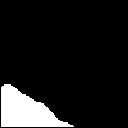

In [21]:
image_utils.array_to_img(y_train[n])

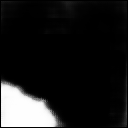

In [22]:
image_utils.array_to_img(pred_train[n])